# Creating a data set for the comparison with Huppenkothen+2017

Main classificatin experiments described in paper Orwat-Kapola+2021 were not directly comparable with the work of Daniela Huppenkothen, because the former classified whole light curves instead of 1024 s segments, and the cadence of the data was 1s/4s instead of 0.125 s.

Here we prepare a data set of 1024 s overlapping segments which are be further segmented into 16 s segments with cadence of 0.125s to make a direct comparison with Huppenkothen+2017.

In order to reduce the amount of generated data, the 1024 s segments created with a stride of 256 s and the 16 s segments are created with a stride of 16 s. The fact that light curve features are observed in only one phase shift position within those 16 s segments can affect the result. 

In [22]:
%load_ext autoreload
%autoreload 2

import sys; sys.path.insert(0, '../../') # add parent folder path where /src folder is
from src import data_preprocessing

from IPython.display import clear_output
import os
import fnmatch
import numpy as np
# import pickle
# import matplotlib.pyplot as plt

raw_data_dir = "../../../data_GRS1915/std1/" # directory path to where lightcurve files are located
raw_file_name_suffix = "_std1_lc.txt" # light curves were saved as txt files which are directly interpretable by numpy

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
# load light curves from text files

lcs=[] # light curves (time stamps, count rate, uncertainty)
lc_ids=[] # observation ids

for root, dirnames, filenames in os.walk(raw_data_dir): #Std1_PCU2
    for filename in fnmatch.filter(filenames, "*{}".format(raw_file_name_suffix)):
        lc = os.path.join(root, filename)
        lc_ids.append(filename.split("_")[0])
        f=np.loadtxt(lc)
        f=np.transpose(f)
        lcs.append(f)
        print("Loaded {} lightcurves".format(len(lcs)))
        clear_output(wait=True)

Loaded 1776 lightcurves


In [ ]:
cadence=1
seg_len_s=128
stride_s=10

segments_counts=[]
segments_times = []
segments_errors=[]
seg_ids=[]


seg_len = seg_len_s//cadence # segment length and stride size in data points
stride = stride_s//cadence



for lc_index, lc in enumerate(binned_lcs):
    if lc_ids[lc_index] in ob_IDs_4s: # filter out observations missing from the 4 second dataset
        if len(lc[1]) >= seg_len: 
            segments = segmentation(lc, seg_len, stride, keep_time_stamps=True, experimental = False, input_cadence=cadence)
        else:
            continue
        if len(segments) > 0:
            segments_times.append(segments[:,0,:])
            segments_counts.append(segments[:,1,:])
            segments_errors.append(segments[:,2,:])
            seg_ids.append(lc_ids[lc_index])
            print("Segmented {}/{} light curves.".format(lc_index+1, len(lcs)))
            clear_output(wait=True)


In [44]:
segmented_lc = data_preprocessing.segmentation(time_series = lcs[1], 
                                               segment_length_sec = 1024, 
                                               stride_sec = 256, 
                                               keep_time_stamps = False, 
                                               input_cadence_sec = 0.125)

In [46]:
segmented_lc[0]

array([[2088.        , 2168.        , 2336.        , ..., 2392.        ,
        2456.        , 2936.        ],
       [ 129.24395537,  131.69662107,  136.70405993, ...,  138.33293173,
         140.17132374,  153.25795249]])

In [30]:
lcs[0][0][-1]-lcs[0][0][0]

1484.75

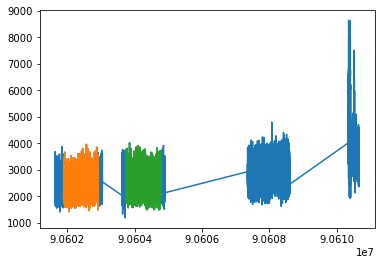

In [43]:
import matplotlib.pyplot as plt

plt.plot(lcs[1][0],lcs[1][1])

plt.plot(segmented_lc[0][0],segmented_lc[0][1])
plt.plot(segmented_lc[1][0],segmented_lc[1][1])

plt.show()

In [37]:
segmented_lc[0][0]

array([3.26427747e+08, 3.26427748e+08, 3.26427748e+08, ...,
       3.26428771e+08, 3.26428771e+08, 3.26428771e+08])

In [13]:
def segmentation(time_series, segment_length_sec, stride_sec, keep_time_stamps=True, input_cadence_sec=4):
    """
    Create a list of 1D (when time_stamps=False) or 2D (when time_stamps=True) arrays, which are overlappig segments of ts.
    Incomplete fragments are rejected.

    time_series = time series to be segmented
    seg_len = length of a segment, 
    stride_sec = step size; difference in the starting position of the consecutive segments
    """
    segment_length = segment_length_sec/input_cadence_sec
    stride = stride_sec/input_cadence_sec
    
    if (segment_length).is_integer() and (stride).is_integer():
        segment_length = int(segment_length)
        stride = int(stride)
    else:
        raise ValueError("segment_length_sec and stride_sec should be multiples of input_cadence_sec")
    
    segments=[]
    for start in range(0, len(time_series[0])-segment_length, stride):
        end=start+segment_length
        if time_series[0][end]-time_series[0][start] != segment_length*input_cadence_sec: #don't allow segments outside of good time intervals
            continue
        if keep_time_stamps==True:
            segments.append(time_series[:,start:end])
        else:
            segments.append(time_series[1:,start:end])
    return np.array(segments)

0.125